# llc parcel simulation + geohash

In [1]:
import os
#from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
from shapely import wkt

%matplotlib inline
from matplotlib import pyplot as plt

import pyinterp.geohash as geohash
import pyinterp.geodetic as geodetic

import mitequinox.utils as ut
import mitequinox.parcels as pa

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.4736390.datarmor0/parcels-55081/libparcels_random_87dc1388-7e1c-4604-8197-785b171e674e.so


In [2]:
ds = xr.open_zarr("/home1/scratch/aponte/parcels/C_b0398_t01.zarr")

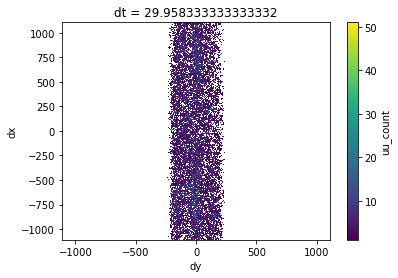

In [6]:
ds["uu_count"].isel(dt=-1).plot()

In [ ]:
ds["uu_count"].isel(dt=-1)

In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=4)
    #
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

---
## load data

In [56]:
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

#pq="trajectory"
pq="mean_interp"
p = pa.parcels_output(root_dir+run_name, parquets=[pq])
df = p[pq]
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,SSU_interp,SSV_interp,Eta_interp,SSS_interp,SST_interp
time,,,,,,,,,,,,,,
2011-11-15,39000000,57.835732,-178.867081,0.0,0.0,0.0,0.0,0.0,0.0,-0.002461,-0.006017,0.060997,33.194778,4.279537
2011-11-15,39000001,58.429878,-178.871994,0.0,0.0,0.0,0.0,0.0,0.0,-0.091730,0.050204,0.075155,33.139637,4.326020
2011-11-15,39000002,59.018066,-178.879623,0.0,0.0,0.0,0.0,0.0,0.0,-0.203138,0.209887,0.169278,32.961617,4.161501
2011-11-15,39000003,59.600288,-178.890015,0.0,0.0,0.0,0.0,0.0,0.0,-0.075768,0.064889,0.242839,32.712219,3.679666
2011-11-15,39000004,60.176525,-178.903275,0.0,0.0,0.0,0.0,0.0,0.0,-0.006189,0.057710,0.222071,32.573410,3.151162


---
## compute geohash indices, reindex and store

In [57]:
# target geohash precision
precision=2

In [58]:
def compute_geohash(df, precision):
    import pyinterp.geohash as geohash
    #index_handler = geohash.index.init_geohash(geohash
    #                                       .storage
    #                                       .MutableMapping(),
    #                                       precision=precision,
    #                                       synchronizer=None
    #                                          )
    #gh = (index_handler
    gh = (geohash
          .encode(df.lon.values, df.lat.values, precision)
          .astype(str)
         )
    return df.assign(geohash=gh)

df = df.map_partitions(compute_geohash, 
                       precision, 
                       meta={**df.dtypes, "geohash": str},
                      )

df = df.persist()
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,SSU_interp,SSV_interp,Eta_interp,SSS_interp,SST_interp,geohash
time,,,,,,,,,,,,,,,
2011-11-15,39000000,57.835732,-178.867081,0.0,0.0,0.0,0.0,0.0,0.0,-0.002461,-0.006017,0.060997,33.194778,4.279537,b4
2011-11-15,39000001,58.429878,-178.871994,0.0,0.0,0.0,0.0,0.0,0.0,-0.091730,0.050204,0.075155,33.139637,4.326020,b4
2011-11-15,39000002,59.018066,-178.879623,0.0,0.0,0.0,0.0,0.0,0.0,-0.203138,0.209887,0.169278,32.961617,4.161501,b4
2011-11-15,39000003,59.600288,-178.890015,0.0,0.0,0.0,0.0,0.0,0.0,-0.075768,0.064889,0.242839,32.712219,3.679666,b4
2011-11-15,39000004,60.176525,-178.903275,0.0,0.0,0.0,0.0,0.0,0.0,-0.006189,0.057710,0.222071,32.573410,3.151162,b4


<AxesSubplot:xlabel='lon', ylabel='lat'>

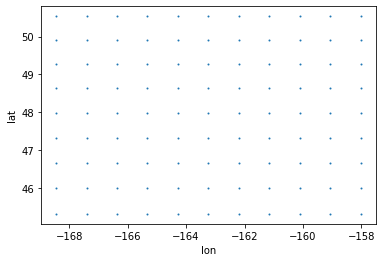

In [55]:
if False:
    _df = df.loc["2011-11-15 00:00:00"].compute()
    _df = _df.set_index("geohash")
    _df.loc["b2"].plot.scatter(x="lon", y="lat", s=1)

In [59]:
#geohash.bounding_box("b2")

### reindex by hash and store

In [7]:
#df_hash = df.reset_index().set_index('hash')
# works if hash type is converted to str

In [60]:
parquet_dir = os.path.join(p.run_dir, "parquets")
pa.store_parquet(parquet_dir, 
                 df,
                 index='geohash',
                 name="geohash_p{}".format(precision),
                 overwrite=True,
                )

deleting existing archive: /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/parquets/geohash_p2
create new archive: /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/parquets/geohash_p2


'/home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/parquets/geohash_p2'

In [61]:
cluster.close()

---

# trial computation

### group by geographical area (hash)

In [ ]:
t_start = df.index.min().compute()
t_end = df.index.max().compute()
delta_t = (t_end - t_start)/pd.Timedelta('1D') # in days

print(t_start)
print(t_end)

In [13]:
count = (df
         .groupby('hash')
         .count()
         .compute()
         ['z'].rename('count')
         .to_frame()
        )
count = count/delta_t

In [14]:
crs = 'EPSG:4326'

def add_geodata(df):

    if type(df.index) is pd.core.indexes.multi.MultiIndex:
        i_hash = df.index.names.index('hash')
        get_hash = lambda r: r.name[i_hash]
    else:
        get_hash = lambda r: r.name

    # converts to geopandas
    df['Coordinates'] = df.apply(lambda r: wkt.loads(geohash
                                                     .string
                                                     .bounding_box(get_hash(r))
                                                     .wkt()
                                                    ), 
                                 axis=1
                                )
    df = gpd.GeoDataFrame(df, geometry='Coordinates', crs=crs)

    df['area'] = df.to_crs({'init': 'epsg:3857'}).area /1e6 / 1e4 # 100km^2 units
    df['density'] = df['count']/count['area']

    return df

In [15]:
count = add_geodata(count)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Text(0.5, 1.0, 'Average number of floats per 100km^2 and per day')

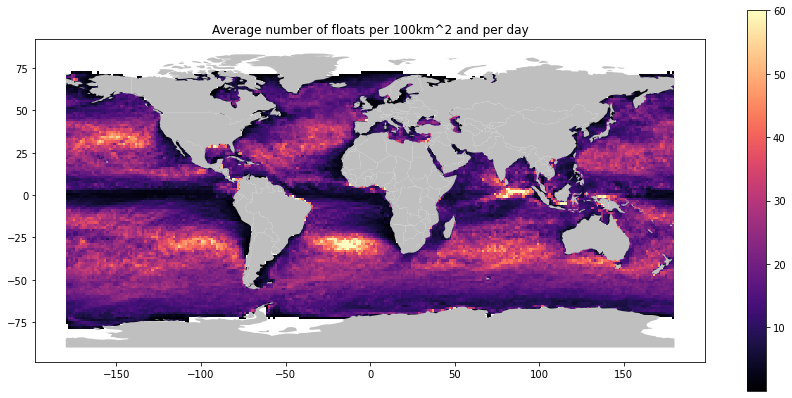

In [16]:
fig, ax = plt.subplots(figsize=(15,7))

count.plot(column='density', vmax=60, cmap='magma', legend=True, ax=ax)
# https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html#creating-a-legend
world.to_crs(crs).plot(ax=ax, color='0.75')

ax.set_title('Average number of floats per 100km^2 and per day')

---
## group by month

In [17]:
#t_bins = pd.date_range(t_start, t_end, freq='1M')
t_bins = pd.date_range(t_start, t_end, freq='1MS') # starts at the beginning of each month
cut = lambda df, bins: pd.cut(df.index.to_series(), bins=bins)
df['time_cut'] = df.map_partitions(cut, t_bins)

In [18]:
count = (df
         .groupby('time_cut')
         .count()['z']
         .compute()
         .rename('count')
         .to_frame()
        )
count['time'] = count.index.to_series().apply(lambda d: d.left)

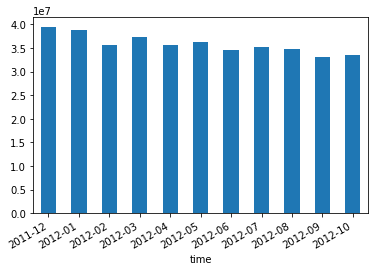

In [19]:
fig, ax = plt.subplots()
count['time'] = count.index.to_series().apply(lambda d: d.left)
count.set_index('time')['count'].plot.bar(ax=ax)
ax.set_xticklabels([pd.Timestamp(t.get_text()).strftime('%Y-%m') for t in ax.get_xticklabels()])
fig.autofmt_xdate()

---
### group by geographical area and month

In [20]:
df

,trajectory,lat,lon,z,hash,time_cut
npartitions=174,,,,,,
,float64,float64,float64,float64,object,category[known]
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


In [21]:
count = (df
         .groupby([df.time_cut, df.hash])
         .count()['z']
         .compute()
         .rename('count')
         .to_frame()
        )
count = count/30 # normalize per number of days
count['time'] = count.index.to_series().apply(lambda v: v[0].left)

In [22]:
count = add_geodata(count)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [23]:
count

count       time  \
time_cut                 hash                          
(2011-12-01, 2012-01-01] 041    13.433333 2011-12-01   
                         043    78.533333 2011-12-01   
                         044    70.200000 2011-12-01   
                         045    61.266667 2011-12-01   
                         046   123.500000 2011-12-01   
...                                   ...        ...   
(2012-10-01, 2012-11-01] zut     0.000000 2012-10-01   
                         zuv     0.000000 2012-10-01   
                         zuw     0.000000 2012-10-01   
                         zux     0.000000 2012-10-01   
                         zuz     0.000000 2012-10-01   

                                                                     Coordinates  \
time_cut                 hash                                                      
(2011-12-01, 2012-01-01] 041   POLYGON ((-178.59400 -78.75000, -178.59400 -77...   
                         043   POLYGON ((-178.59400 -77.34380, -178.59400 -75...   
                         044   POLYGON ((-177.18800 -78.75000, -177.18800 -77...   
                         045   POLYGON ((-175.78100 -78.75000, -175.78100 -77...   
                         046   POLYGON ((-177.18800 -77.34380, -177.18800 -75...   
...                                                                          ...   
(2012-10-01, 2012-11-01] zut   POLYGON ((175.78100 70.31250, 175.78100 71.718...   
                         zuv   POLYGON ((175.78100 71.71880, 175.78100 73.125...   
                         zuw   POLYGON ((177.18800 70.31250, 177.18800 71.718...   
                         zux   POLYGON ((178.59400 70.31250, 178.59400 71.718...   
                         zuz   POLYGON ((178.59400 71.71880, 178.59400 73.125...   

                                    area    density  
time_cut                 hash                        
(2011-12-01, 2012-01-01] 041   11.843221   1.134263  
                         043   10.614102   7.398961  
                         044   11.851645   5.923229  
                         045   11.843221   5.173142  
                         046   10.621651  11.627194  
...                                  ...        ...  
(2012-10-01, 2012-11-01] zut    7.540714   0.000000  
                         zuv    8.122636   0.000000  
                         zuw    7.535355   0.000000  
                         zux    7.535355   0.000000  
                         zuz    8.116863   0.000000  

[216799 rows x 5 columns]

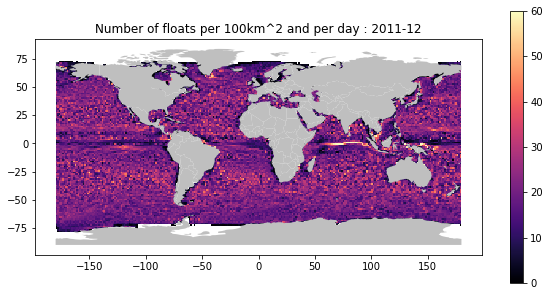

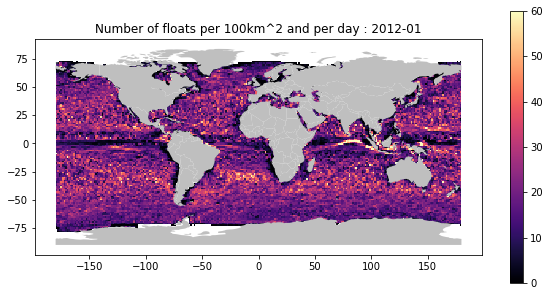

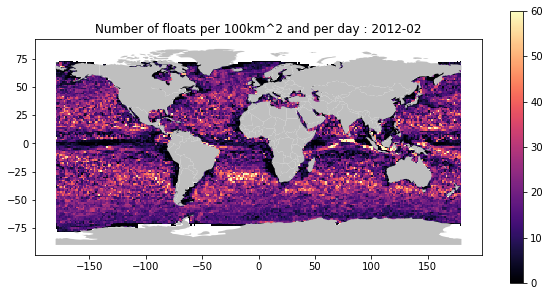

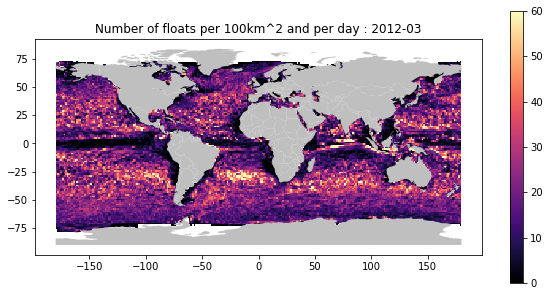

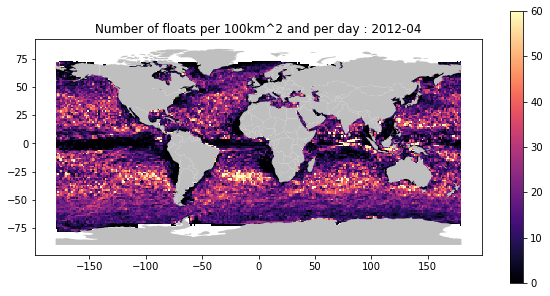

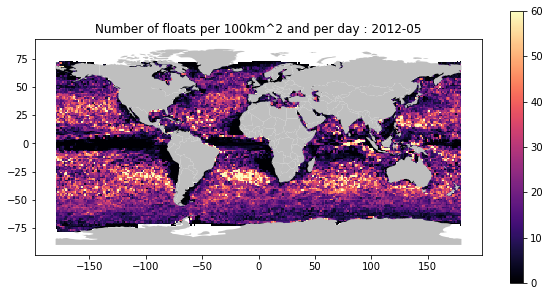

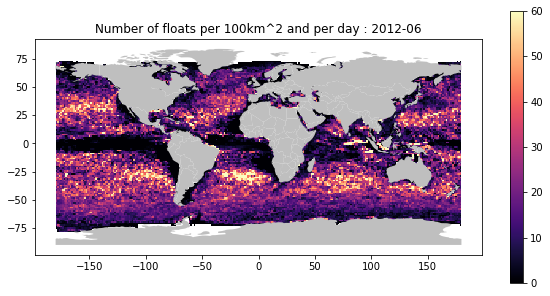

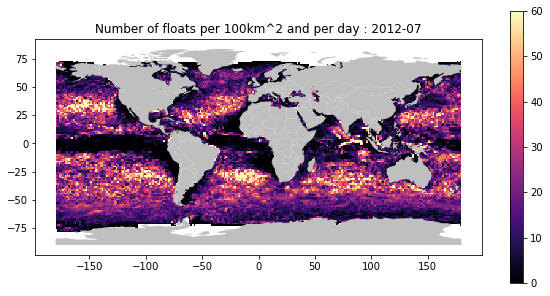

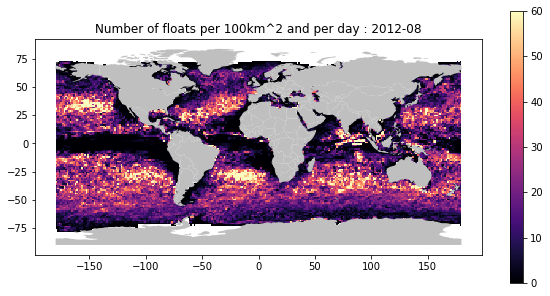

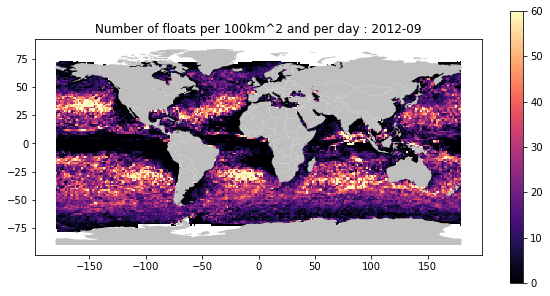

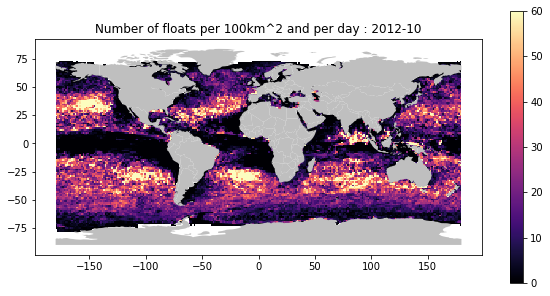

In [24]:
for t in count.index.get_level_values(0).unique():

    c = count.loc[[t]]
    
    fig, ax = plt.subplots(figsize=(10,5))
    c.plot(column='density', vmax=60, cmap='magma', legend=True, ax=ax)
    # https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html#creating-a-legend
    world.to_crs(crs).plot(ax=ax, color='0.75')

    ax.set_title('Number of floats per 100km^2 and per day : {}'.format(t.left.strftime('%Y-%m')))

In [25]:
t_bins

DatetimeIndex(['2011-12-01', '2012-01-01', '2012-02-01', '2012-03-01',
               '2012-04-01', '2012-05-01', '2012-06-01', '2012-07-01',
               '2012-08-01', '2012-09-01', '2012-10-01', '2012-11-01'],
              dtype='datetime64[ns]', freq='MS')

In [62]:
ds = count.reset_index().to_xarray()

In [63]:
ds

<xarray.Dataset>
Dimensions:      (index: 216799)
Coordinates:
  * index        (index) int64 0 1 2 3 4 ... 216794 216795 216796 216797 216798
Data variables:
    time_cut     (index) object (2011-12-01, 2012-01-01] ... (2012-10-01, 201...
    hash         (index) object '041' '043' '044' '045' ... 'zuw' 'zux' 'zuz'
    count        (index) float64 13.43 78.53 70.2 61.27 ... 0.0 0.0 0.0 0.0
    time         (index) datetime64[ns] 2011-12-01 2011-12-01 ... 2012-10-01
    Coordinates  (index) object POLYGON ((-178.594 -78.75, -178.594 -77.3438,...
    area         (index) float64 11.84 10.61 11.85 11.84 ... 7.535 7.535 8.117
    density      (index) float64 1.134 7.399 5.923 5.173 ... 0.0 0.0 0.0 0.0

In [45]:
count.eq?

Signature: count.eq(other, axis='columns', level=None)
Docstring:
Get Equal to of dataframe and other, element-wise (binary operator `eq`).

Among flexible wrappers (`eq`, `ne`, `le`, `lt`, `ge`, `gt`) to comparison
operators.

Equivalent to `==`, `=!`, `<=`, `<`, `>=`, `>` with support to choose axis
(rows or columns) and level for comparison.

Parameters
----------
other : scalar, sequence, Series, or DataFrame
    Any single or multiple element data structure, or list-like object.
axis : {0 or 'index', 1 or 'columns'}, default 'columns'
    Whether to compare by the index (0 or 'index') or columns
    (1 or 'columns').
level : int or label
    Broadcast across a level, matching Index values on the passed
    MultiIndex level.

Returns
-------
DataFrame of bool
    Result of the comparison.

See Also
--------
DataFrame.eq : Compare DataFrames for equality elementwise.
DataFrame.ne : Compare DataFrames for inequality elementwise.
DataFrame.le : Compare DataFrames for less than inequal

In [57]:
df = count.reset_index().groupby('hash').get_group('zuv') #'041'

In [58]:
df

,time_cut,hash,count,time,Coordinates,area,density
19705,"(2011-12-01, 2012-01-01]",zuv,0.0,2011-12-01,"POLYGON ((175.78100 71.71880, 175.78100 73.125...",8.122636,0.000000
39414,"(2012-01-01, 2012-02-01]",zuv,0.0,2012-01-01,"POLYGON ((175.78100 71.71880, 175.78100 73.125...",8.122636,0.000000
59123,"(2012-02-01, 2012-03-01]",zuv,0.0,2012-02-01,"POLYGON ((175.78100 71.71880, 175.78100 73.125...",8.122636,0.000000
78832,"(2012-03-01, 2012-04-01]",zuv,0.0,2012-03-01,"POLYGON ((175.78100 71.71880, 175.78100 73.125...",8.122636,0.000000
98541,"(2012-04-01, 2012-05-01]",zuv,0.0,2012-04-01,"POLYGON ((175.78100 71.71880, 175.78100 73.125...",8.122636,0.000000
118250,"(2012-05-01, 2012-06-01]",zuv,0.0,2012-05-01,"POLYGON ((175.78100 71.71880, 175.78100 73.125...",8.122636,0.000000
137959,"(2012-06-01, 2012-07-01]",zuv,0.0,2012-06-01,"POLYGON ((175.78100 71.71880, 175.78100 73.125...",8.122636,0.000000
157668,"(2012-07-01, 2012-08-01]",zuv,7.4,2012-07-01,"POLYGON ((175.78100 71.71880, 175.78100 73.125...",8.122636,0.911034
177377,"(2012-08-01, 2012-09-01]",zuv,0.0,2012-08-01,"POLYGON ((175.78100 71.71880, 175.78100 73.125...",8.122636,0.000000
197086,"(2012-09-01, 2012-10-01]",zuv,0.0,2012-09-01,"POLYGON ((175.78100 71.71880, 175.78100 73.125...",8.122636,0.000000


In [59]:
df['count'].eq(0)

19705      True
39414      True
59123      True
78832      True
98541      True
118250     True
137959     True
157668    False
177377     True
197086     True
216795     True
Name: count, dtype: bool

In [55]:
df[df['count'].eq(0)]

,time_cut,hash,count,time,Coordinates,area,density
19708,"(2011-12-01, 2012-01-01]",zuz,0.0,2011-12-01,"POLYGON ((178.59400 71.71880, 178.59400 73.125...",8.116863,0.0
39417,"(2012-01-01, 2012-02-01]",zuz,0.0,2012-01-01,"POLYGON ((178.59400 71.71880, 178.59400 73.125...",8.116863,0.0
59126,"(2012-02-01, 2012-03-01]",zuz,0.0,2012-02-01,"POLYGON ((178.59400 71.71880, 178.59400 73.125...",8.116863,0.0
78835,"(2012-03-01, 2012-04-01]",zuz,0.0,2012-03-01,"POLYGON ((178.59400 71.71880, 178.59400 73.125...",8.116863,0.0
98544,"(2012-04-01, 2012-05-01]",zuz,0.0,2012-04-01,"POLYGON ((178.59400 71.71880, 178.59400 73.125...",8.116863,0.0
118253,"(2012-05-01, 2012-06-01]",zuz,0.0,2012-05-01,"POLYGON ((178.59400 71.71880, 178.59400 73.125...",8.116863,0.0
137962,"(2012-06-01, 2012-07-01]",zuz,0.0,2012-06-01,"POLYGON ((178.59400 71.71880, 178.59400 73.125...",8.116863,0.0
177380,"(2012-08-01, 2012-09-01]",zuz,0.0,2012-08-01,"POLYGON ((178.59400 71.71880, 178.59400 73.125...",8.116863,0.0
197089,"(2012-09-01, 2012-10-01]",zuz,0.0,2012-09-01,"POLYGON ((178.59400 71.71880, 178.59400 73.125...",8.116863,0.0
216798,"(2012-10-01, 2012-11-01]",zuz,0.0,2012-10-01,"POLYGON ((178.59400 71.71880, 178.59400 73.125...",8.116863,0.0


In [44]:
count.reset_index().groupby('hash').apply(lambda df: df['count'].eq(0))

In [35]:
t_index = list(count.index.get_level_values(0).unique())

In [39]:
c = count.loc[[t_index[4]]]

In [40]:
c

count       time  \
time_cut                 hash                          
(2012-04-01, 2012-05-01] 041     5.433333 2012-04-01   
                         043    48.533333 2012-04-01   
                         044    56.600000 2012-04-01   
                         045    68.800000 2012-04-01   
                         046   175.933333 2012-04-01   
...                                   ...        ...   
                         zut    13.300000 2012-04-01   
                         zuv     0.000000 2012-04-01   
                         zuw    84.533333 2012-04-01   
                         zux    32.600000 2012-04-01   
                         zuz     0.000000 2012-04-01   

                                                                     Coordinates  \
time_cut                 hash                                                      
(2012-04-01, 2012-05-01] 041   POLYGON ((-178.59400 -78.75000, -178.59400 -77...   
                         043   POLYGON ((-178.59400 -77.34380, -178.59400 -75...   
                         044   POLYGON ((-177.18800 -78.75000, -177.18800 -77...   
                         045   POLYGON ((-175.78100 -78.75000, -175.78100 -77...   
                         046   POLYGON ((-177.18800 -77.34380, -177.18800 -75...   
...                                                                          ...   
                         zut   POLYGON ((175.78100 70.31250, 175.78100 71.718...   
                         zuv   POLYGON ((175.78100 71.71880, 175.78100 73.125...   
                         zuw   POLYGON ((177.18800 70.31250, 177.18800 71.718...   
                         zux   POLYGON ((178.59400 70.31250, 178.59400 71.718...   
                         zuz   POLYGON ((178.59400 71.71880, 178.59400 73.125...   

                                    area    density  
time_cut                 hash                        
(2012-04-01, 2012-05-01] 041   11.843221   0.458772  
                         043   10.614102   4.572533  
                         044   11.851645   4.775709  
                         045   11.843221   5.809230  
                         046   10.621651  16.563651  
...                                  ...        ...  
                         zut    7.540714   1.763759  
                         zuv    8.122636   0.000000  
                         zuw    7.535355  11.218229  
                         zux    7.535355   4.326273  
                         zuz    8.116863   0.000000  

[19709 rows x 5 columns]

## Close cluster

In [ ]:
cluster.close()